In [196]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

Get sorted class label counts

In [197]:
from collections import Counter
location=[]
label=[]
with open('data/semi_fungi/l_train.txt', 'r') as f:
    for line in f:
        # Split each line by whitespace
        parts = line.split()
        # Append the first part to location and the second part as an integer to label
        location.append(parts[0])
        label.append(int(parts[-1]))
print(label)

label_counts = Counter(label)


# Group labels by frequency and shuffle within each frequency group
sorted_label_counts = sorted(label_counts.items(), key=lambda x: -x[1])  # Sort by frequency (desc)
print(sorted_label_counts)
frequencies = {}
sorted_labels=[]
for label, freq in sorted_label_counts:
    sorted_labels.append(label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

### Change in accuracy per class

In [198]:
def get_class_accuracies(FILE, sorted_labels):
    data = np.loadtxt(FILE, dtype=int)

    # Split data into target and predicted labels
    y_true = data[:, 0]  # target labels (first column)
    y_pred = data[:, 1]  # predicted labels (second column)

    # Count the number of true positives for each class
    true_positives = {}
    unique_classes = np.unique(y_true)

    for cls in unique_classes:
        true_positives[cls] = np.sum((y_true == cls) & (y_pred == cls))

    # Create a list to store true positives in the order of frequency
    ordered_true_positives = [true_positives[cls] for cls in sorted_labels]

    class_accuracies = np.array(ordered_true_positives).reshape(1, -1)
    return class_accuracies[0]

In [199]:
def plot_difference(BASELINE_FILE, NEW_FILE, sorted_labels):
    data1 = get_class_accuracies(BASELINE_FILE, sorted_labels)
    data2 = get_class_accuracies(NEW_FILE, sorted_labels)
    difference_data = data2/20 - data1/20
    # Replace this with your actual TP data for 200 classes
    tp_counts = difference_data  # Example data with some values below zero
    classes = np.arange(1, len(tp_counts) + 1)

    # Calculate EMA with pandas for smoother trend line
    tp_series = pd.Series(tp_counts)
    ema_tp_counts = tp_series.ewm(span=20, adjust=False).mean().values  # Span controls the level of smoothing

    values = difference_data.flatten()
    # Plot the bar graph for TP counts
    plt.figure(figsize=(14, 6))
    bars = plt.bar(np.arange(len(difference_data)), values, color=['green' if v > 0 else 'red' for v in values])
    # Overlay the EMA line
    plt.plot(classes, ema_tp_counts, color="black", linewidth=0.5, label="EMA (20)")

    # Fill the region between EMA line and zero line
    plt.fill_between(classes, ema_tp_counts, 0, where=(ema_tp_counts >= 0), color="green", alpha=0.2)
    plt.fill_between(classes, ema_tp_counts, 0, where=(ema_tp_counts < 0), color="red", alpha=0.2)

    # Add labels and title
    plt.title("Change in accuracy from threshold 0.80 to 0.95 for each class")
    plt.xlabel("Classes (sorted by frequency)")
    plt.ylabel("Change in accuracy")
    plt.axhline(0, color="black", linewidth=0.5)  # Add a baseline at y=0
    plt.legend()

    plt.show()

Comparing static threshold vs linear decay threshold

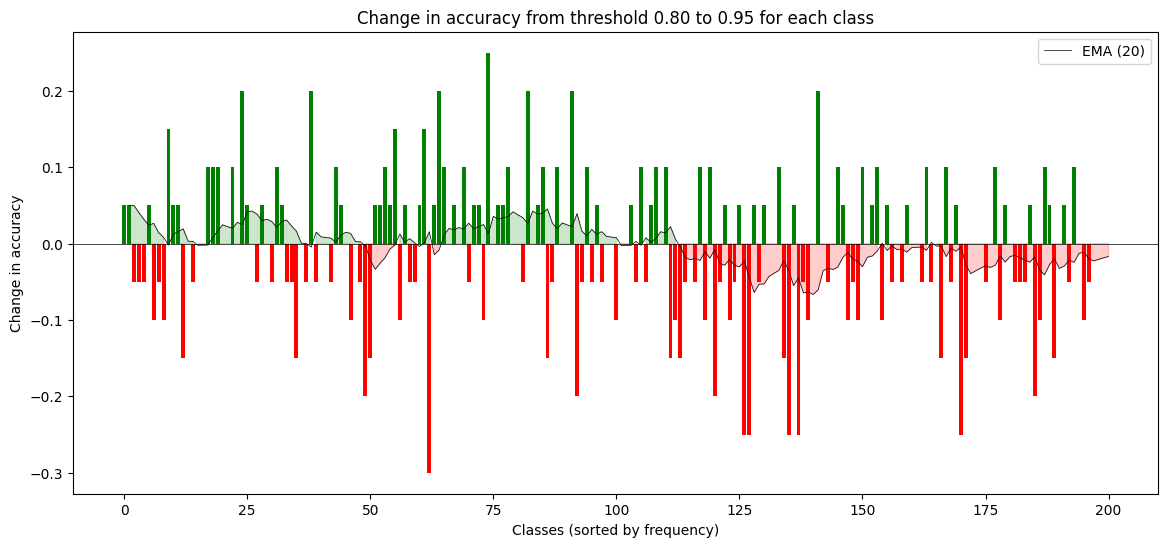

In [200]:
BASELINE_FILE = "results/semi_fungi_PL_in_thres_95/test/pl.txt"
NEW_FILE = "results/semi_fungi_PL_in_0_95/test/pl.txt"
plot_difference(BASELINE_FILE, NEW_FILE, sorted_labels)

Comparing Static Threshold vs Adaptive decay

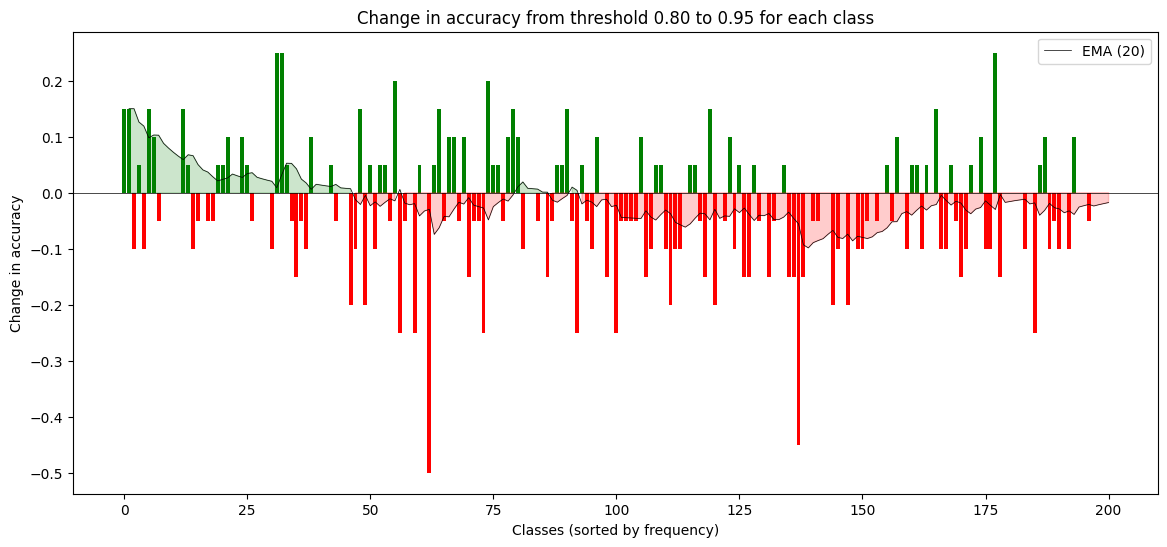

In [201]:
BASELINE_FILE = "results/semi_fungi_PL_in_thres_95/test/pl.txt"
NEW_FILE = "results/semi_fungi_PL_global_adaptive_thres/test/pl.txt"
plot_difference(BASELINE_FILE, NEW_FILE, sorted_labels)

Comparing Linear decay vs adaptive decay

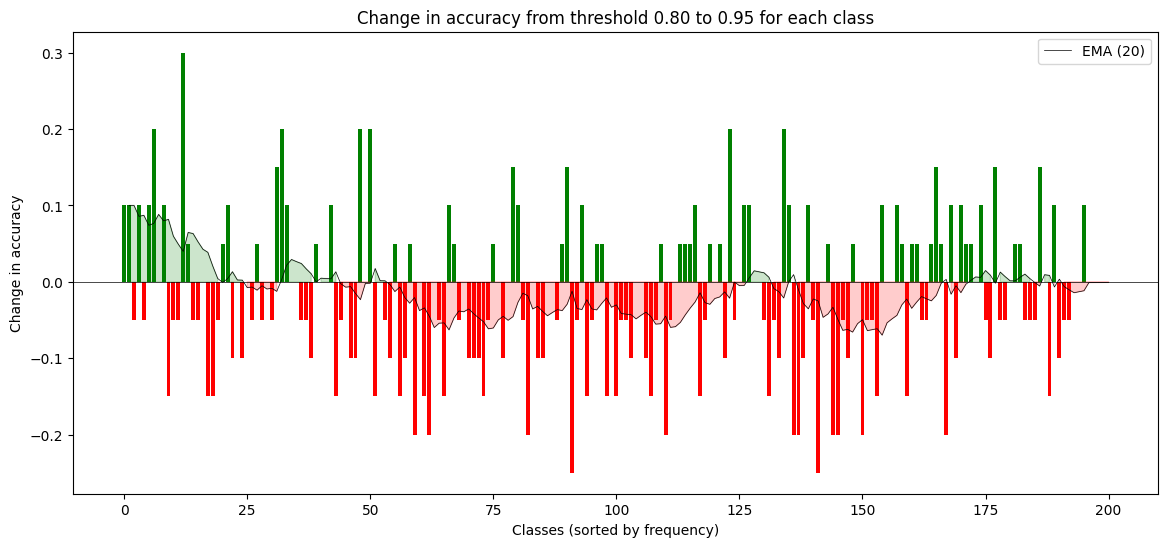

In [202]:
BASELINE_FILE = "results/semi_fungi_PL_in_0_95/test/pl.txt"
NEW_FILE = "results/semi_fungi_PL_global_adaptive_thres/test/pl.txt"
plot_difference(BASELINE_FILE, NEW_FILE, sorted_labels)

### Comparative Analysis of Accuracies

In [203]:
BASELINE1_FILE = "results/semi_fungi_PL_in_thres_80/test/pl.txt"
BASELINE2_FILE = "results/semi_fungi_PL_in_thres_95/test/pl.txt"
NEW_FILE = "results/semi_fungi_PL_in_0_95/test/pl.txt"

In [204]:
acc1 = get_class_accuracies(BASELINE1_FILE, sorted_labels)[0]
acc2 = get_class_accuracies(BASELINE2_FILE, sorted_labels)[0]
acc3 = get_class_accuracies(NEW_FILE, sorted_labels)[0]

In [205]:
acc1

np.int64(18)

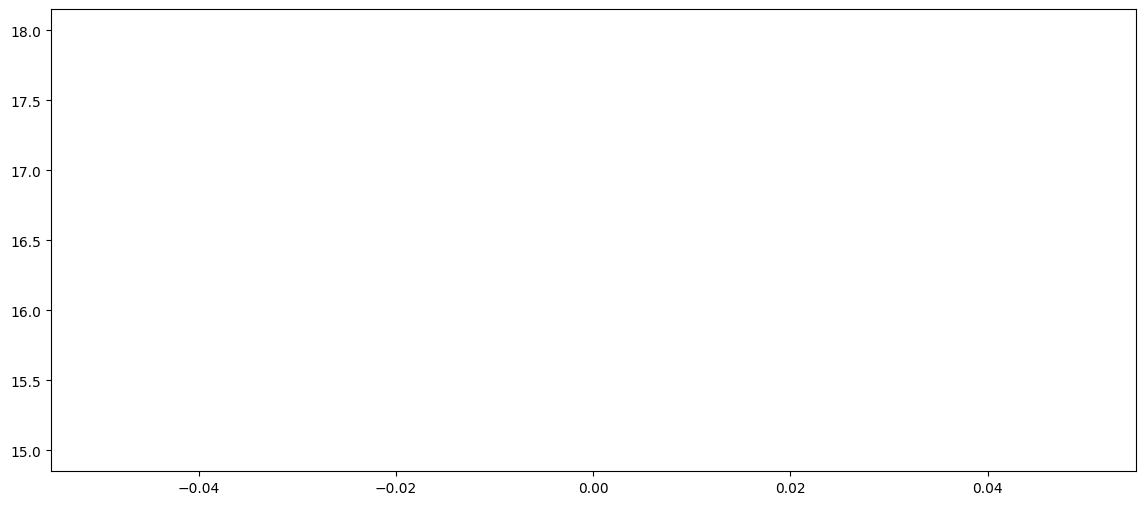

In [206]:
plt.figure(figsize=(14, 6))
plt.plot(acc1, color = "red", label="Threshold 0.80", alpha=0.5)
plt.plot(acc2, color = "green", label="Threshold 0.95", alpha=0.5)
plt.plot(acc3, color = "blue", label="Threshold 0.95 with 0.2 difference")

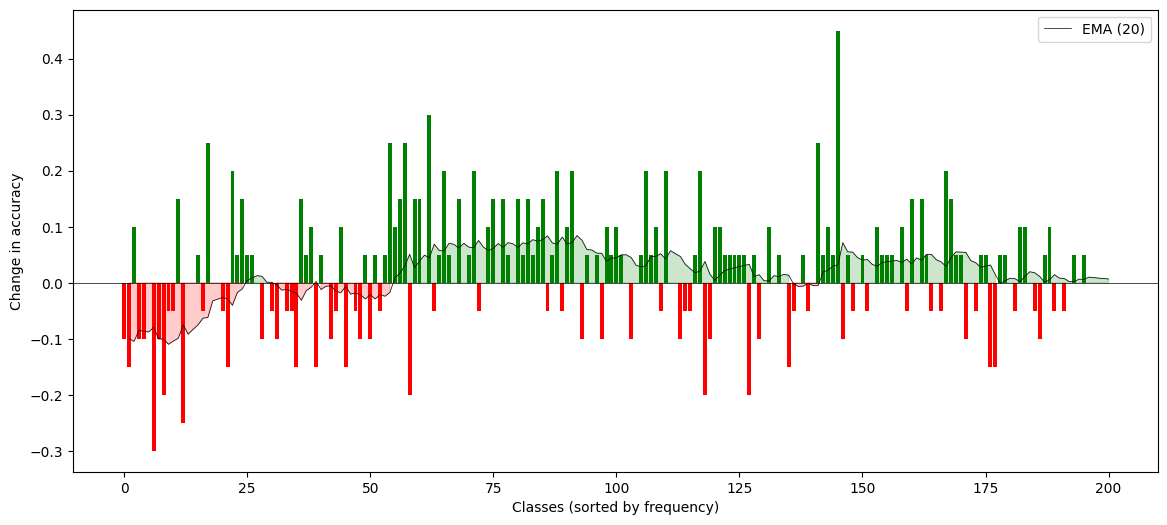

In [207]:
data1 = np.loadtxt(BASELINE1_FILE, dtype=int)
data2 = np.loadtxt(BASELINE2_FILE, dtype=int)
data3 = np.loadtxt(NEW_FILE, dtype=int)

# Replace this with your actual TP data for 200 classes
# tp_counts = difference_data  # Example data with some values below zero
# classes = np.arange(1, len(tp_counts) + 1)

# Calculate EMA with pandas for smoother trend line
# tp_series = pd.Series(tp_counts)
# ema_tp_counts = tp_series.ewm(span=20, adjust=False).mean().values  # Span controls the level of smoothing

values = difference_data.flatten()
# Plot the bar graph for TP counts
plt.figure(figsize=(14, 6))
bars = plt.bar(np.arange(len(difference_data)), values, color=['green' if v > 0 else 'red' for v in values])
# Overlay the EMA line
plt.plot(classes, ema_tp_counts, color="black", linewidth=0.5, label="EMA (20)")

# Fill the region between EMA line and zero line
plt.fill_between(classes, ema_tp_counts, 0, where=(ema_tp_counts >= 0), color="green", alpha=0.2)
plt.fill_between(classes, ema_tp_counts, 0, where=(ema_tp_counts < 0), color="red", alpha=0.2)

# Add labels and title
#plt.title("Change in accuracy from threshold 0.80 to 0.95 for each class")
plt.xlabel("Classes (sorted by frequency)")
plt.ylabel("Change in accuracy")
plt.axhline(0, color="black", linewidth=0.5)  # Add a baseline at y=0
plt.legend()

plt.show()